In [7]:
%pip install rdkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 2.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
df=pd.read_csv("balanced_dataset.csv")

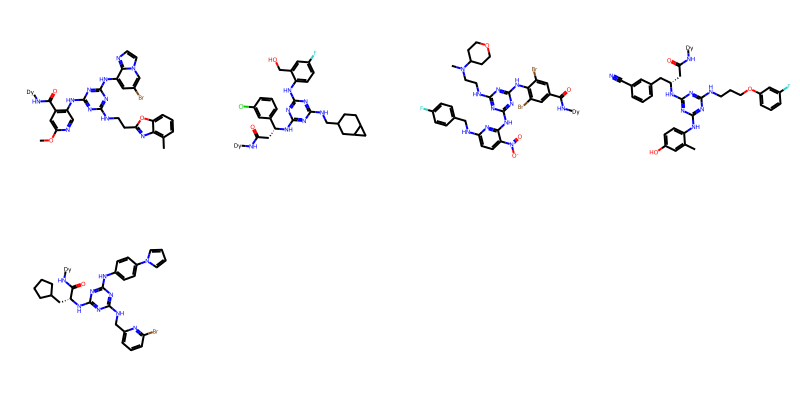

In [11]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

sample_smiles=df["molecule_smiles"][0:5].values
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,molsPerRow=4,subImgSize=(200,200))
grid

In [12]:
%pip install torch_geometric
%pip install deepchem
%pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
  Using cached deepchem-2.8.0-py3-none-any.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 7.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.1
    Uninstalling scipy-1.8.1:
      Successfully uninstalled scipy-1.8.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os.path as osp
import torch
from torch_geometric.data import Dataset
import pandas as pd
import deepchem as dc
from tqdm import tqdm
from rdkit import Chem 
import numpy as np

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
    
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            mol = Chem.MolFromSmiles(row["molecule_smiles"])
            f = featurizer._featurize(mol)
            data = f.to_pyg_graph()
            if not self.test:  # Only assign label if not a test set
                data.y = self._get_label(row["binds"])
            data.smiles = row["molecule_smiles"]
            if self.test:
                torch.save(data, 
                    osp.join(self.processed_dir, 
                             f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    osp.join(self.processed_dir, 
                             f'data_{index}.pt'))

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(osp.join(self.processed_dir, 
                             f'data_test_{idx}.pt'))
        else:
            data = torch.load(osp.join(self.processed_dir, 
                             f'data_{idx}.pt'))        
        return data


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Init Plugin
Init Graph Optimizer
Init Kernel


In [14]:
import pandas as pd
from sklearn.utils import shuffle

# Shuffle the dataframe
df_shuffled = shuffle(df)

# Define the split ratio
split_ratio = 0.8
split_index = int(len(df_shuffled) * split_ratio)

# Split the dataframe
train_dataset_csv = df_shuffled[:split_index]
test_dataset_csv = df_shuffled[split_index:]

# Calculate percentage of rows with label 0 in column 'A' for train_dataset
train_label_0_percentage = (train_dataset_csv['binds'] == 0).mean() * 100

# Calculate percentage of rows with label 0 in column 'A' for valid_dataset
test_label_0_percentage = (test_dataset_csv['binds'] == 0).mean() * 100

print(train_label_0_percentage)
print(test_label_0_percentage)




49.97083333333333
50.11666666666667


In [15]:
train_dataset_csv

,Unnamed: 0,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
8264,8264,74919063,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,NCc1ccncn1,Cn1nccc1CN,Cn1nccc1CNc1nc(NCc2ccncn2)nc(NC(Cc2ccccc2)C(=O...,BRD4,0
54800,54800,100095792,O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...,Nc1ccc2c(c1)CNC2=O,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(Nc4ccc5c(c4)CNC5=O)nc(N[C@@H](...,BRD4,1
11898,11898,119466149,O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2c...,N#Cc1ncc(N)cc1C(F)(F)F,Nc1nc(-c2ccc(Cl)cc2)cs1,N#Cc1ncc(Nc2nc(Nc3nc(-c4ccc(Cl)cc4)cs3)nc(N[C@...,sEH,0
51769,51769,15446042,CC(C)(C)OC(=O)N1C[C@@H](NC(=O)OCC2c3ccccc3-c3c...,COC(=O)c1cncc(N)c1,Nc1nnn[nH]1,COC(=O)c1cncc(Nc2nc(Nc3nnn[nH]3)nc(N[C@@H]3CN(...,sEH,1
38492,38492,167230892,O=C(Nc1cc(C(=O)O)ccc1Cl)OCC1c2ccccc2-c2ccccc21,Cl.NCC(=O)NC1CCC1,Nc1cc2cccnc2c2ncccc12,O=C(CNc1nc(Nc2cc(C(=O)N[Dy])ccc2Cl)nc(Nc2cc3cc...,sEH,1
...,...,...,...,...,...,...,...,...
23516,23516,248177082,O=C(O)C[C@@H](Cc1ccc(Cl)cc1Cl)NC(=O)OCC1c2cccc...,Nc1cc(F)cc(F)c1,Cn1cc(CN)cn1,Cn1cc(CNc2nc(Nc3cc(F)cc(F)c3)nc(N[C@@H](CC(=O)...,BRD4,0
332,332,211192791,O=C(Nc1cccc(C(=O)O)c1C(=O)O)OCC1c2ccccc2-c2ccc...,Nc1ccc(N2CCC=C(N3CCOCC3)C2=O)cc1,Cc1cc(N)n[nH]1,Cc1cc(Nc2nc(Nc3ccc(N4CCC=C(N5CCOCC5)C4=O)cc3)n...,BRD4,0
56539,56539,207657164,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,Cl.NCc1cnc2n1CCOC2,Cl.NCc1cc(Br)no1,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCc4cc(Br)no4)n...,sEH,1
14050,14050,141733316,O=C(Nc1c(C(=O)O)cnn1CCO)OCC1c2ccccc2-c2ccccc21,CCOC(=O)c1cnc(N)cn1,Cl.Cl.NCC=Cc1cccnc1,CCOC(=O)c1cnc(Nc2nc(NCC=Cc3cccnc3)nc(Nc3c(C(=O...,sEH,0


In [16]:
test_dataset_csv

,Unnamed: 0,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
19122,19122,103158791,O=C(N[C@@H](Cc1ccccc1F)C(=O)O)OCC1c2ccccc2-c2c...,NCC1CC2(CC2)CO1,Nc1nc2cccc(Br)n2n1,O=C(N[Dy])[C@H](Cc1ccccc1F)Nc1nc(NCC2CC3(CC3)C...,sEH,0
20857,20857,265095032,O=C(O)C[C@H](Cc1ccc(Br)cc1)NC(=O)OCC1c2ccccc2-...,Cc1cc(F)ncc1CN,Cl.Cl.NCCn1cc(C2CC2)nn1,Cc1cc(F)ncc1CNc1nc(NCCn2cc(C3CC3)nn2)nc(N[C@H]...,sEH,0
10205,10205,276929745,O=C(O)C[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2c...,COC(C)(CN)C1CC1,Cc1ccc(S(C)(=O)=O)cc1N,COC(C)(CNc1nc(Nc2cc(S(C)(=O)=O)ccc2C)nc(N2Cc3c...,BRD4,0
43810,43810,103942180,O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2cc...,Cc1nnc(CCCN)s1.Cl,COC(=O)c1ccsc1N,COC(=O)c1ccsc1Nc1nc(NCCCc2nnc(C)s2)nc(N[C@@H](...,HSA,1
11896,11896,199099819,O=C(Nc1ccc(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,NCc1cccc(C(F)(F)F)n1,Nc1nc2c(s1)CCCC2,O=C(N[Dy])c1cc(Cl)ccc1Nc1nc(NCc2cccc(C(F)(F)F)...,HSA,0
...,...,...,...,...,...,...,...,...
40516,40516,167626231,O=C(Nc1cc(C(=O)O)ccc1Cl)OCC1c2ccccc2-c2ccccc21,Nc1ccc(OC(F)F)cc1,NCCc1nccc(C2CC2)n1,O=C(N[Dy])c1ccc(Cl)c(Nc2nc(NCCc3nccc(C4CC4)n3)...,HSA,1
8312,8312,106654112,O=C(N[C@@H](Cc1cccs1)C(=O)O)OCC1c2ccccc2-c2ccc...,Nc1cccc(N2CCCC2)c1,CCC1COCCN1CCN.Cl.Cl,CCC1COCCN1CCNc1nc(Nc2cccc(N3CCCC3)c2)nc(N[C@@H...,sEH,0
10648,10648,61690677,Cc1ccccc1[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2c...,Cl.Nc1ccc(O)cc1Cl,Nc1cc(F)c(F)cc1Br,Cc1ccccc1[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(O)cc2...,BRD4,0
57913,57913,270952949,O=C(O)C[C@H](Cc1ccc(I)cc1)NC(=O)OCC1c2ccccc2-c...,NCCC1CSC1,Cl.NCCNC(=O)c1ccccc1F,O=C(C[C@H](Cc1ccc(I)cc1)Nc1nc(NCCNC(=O)c2ccccc...,sEH,1


In [17]:
train_dataset_csv=train_dataset_csv.to_csv("train_dataset.csv")
test_dataset_csv=test_dataset_csv.to_csv("test_dataset.csv")

In [38]:
train_dataset=MoleculeDataset(root='./train_dataset',filename="train_dataset.csv")
test_dataset=MoleculeDataset(root='./test_dataset',filename="test_dataset.csv")

In [33]:
train_dataset

MoleculeDataset(48000)

In [34]:
train_dataset[0]

Data(x=[35, 30], edge_index=[2, 76], edge_attr=[76, 11], y=[1], smiles='Cn1nccc1CNc1nc(NCc2ccncn2)nc(NC(Cc2ccccc2)C(=O)N[Dy])n1')

In [35]:
test_dataset[0]

Data(x=[40, 30], edge_index=[2, 90], edge_attr=[90, 11], y=[1], smiles='O=C(N[Dy])[C@H](Cc1ccccc1F)Nc1nc(NCC2CC3(CC3)CO2)nc(Nc2nc3cccc(Br)n3n2)n1')

In [36]:
train_dataset[1]

Data(x=[44, 30], edge_index=[2, 98], edge_attr=[98, 11], y=[1], smiles='Cc1cc2cc(CNc3nc(Nc4ccc5c(c4)CNC5=O)nc(N[C@@H](Cc4ccc(F)cc4F)C(=O)N[Dy])n3)ccc2[nH]1')

In [37]:
test_dataset[1]

Data(x=[42, 30], edge_index=[2, 92], edge_attr=[92, 11], y=[1], smiles='Cc1cc(F)ncc1CNc1nc(NCCn2cc(C3CC3)nn2)nc(N[C@H](CC(=O)N[Dy])Cc2ccc(Br)cc2)n1')

In [ ]:
#dataset=MoleculeDataset(root='/kaggle/working/',filename="/kaggle/working/balanced_dataset")

In [39]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling,GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes=2
        embedding_size=1024
        
        #GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads = 3, dropout=0.3)
        self.head_transforml = Linear(embedding_size*3, embedding_size) 
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        
        self.conv2 = GATConv(embedding_size, embedding_size, heads = 3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size) 
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        
        self.conv3 = GATConv(embedding_size, embedding_size, heads = 3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size) 
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)   

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)   

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First Block
        x = self.conv1(x, edge_index)
        x = self.head_transforml(x)
        
        x , edge_index, edge_attr, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)
        x1 = torch.cat ([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        
        # Second Block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        
        x , edge_index, edge_attr, batch_index, _, _ = self.pool2(x, edge_index, None, batch_index)
        x2 = torch.cat ([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        
        # Third Block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        
        x , edge_index, edge_attr, batch_index, _, _ = self.pool3(x, edge_index, None, batch_index)
        x3 = torch.cat ([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        
        # Concat pooled vectors
        x = x1 + x2 + x3
        
        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        
        return x
    

In [40]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model=GNN(feature_size=train_dataset[0].x.shape[1])
model=model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 17954818


GNN(
  (conv1): GATConv(30, 1024, heads=3)
  (head_transforml): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [41]:
weights = torch.tensor([1,10], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        

In [42]:
NUM_GRAPHS_PER_BATCH = 256
train_loader=DataLoader(train_dataset,batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [43]:
def train(epoch):
    #Enumerate over the data
    all_preds=[]
    all_labels=[]
    for _,batch in enumerate(tqdm(train_loader)):
        #Use GPU
        batch.to(device)
        #Reset gradients
        optimizer.zero_grad()
        #Passing the mode features and the connection info
        pred=model(batch.x.float(),batch.edge_attr.float(),batch.edge_index,batch.batch)
        #Calculating the loss and gradients
        loss=torch.sqrt(loss_fn(pred,batch.y))
        loss.backward()
        #Update using the gradients
        optimizer.step()
        
        all_preds.append(np.argmax(pred.cpu().detach().numpy(),axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds=np.concatenate(all_preds).ravel()
    all_labels=np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds,all_labels,epoch,"train")
    return loss


In [44]:
def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
    except:
        print(f"ROC AUC: notdefined")

In [45]:
def test(epoch):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss=torch.sqrt(loss_fn(pred,batch.y))
        all_preds.append(np.argmax(pred.cpu().detach().numpy(),axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


In [46]:
import torch
import pickle
import matplotlib.pyplot as plt

# Initialize lists to store the loss values
train_losses = []
test_losses = []

# Training loop
for epoch in range(100):
    # Training
    model.train()
    loss = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    train_losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")
    
    model.eval()
    if epoch % 5 == 0:
        loss = test(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        test_losses.append((epoch, loss))
        print(f"Epoch {epoch} | Test Loss {loss}")
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Save the loss values
with open('train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open('test_losses.pkl', 'wb') as f:
    pickle.dump(test_losses, f)

# Load the loss values (for demonstration purposes)
with open('train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open('test_losses.pkl', 'rb') as f:
    test_losses = pickle.load(f)

# Plot the training and testing loss curves
epochs = range(100)
test_epochs, test_losses_values = zip(*test_losses)  # Unpack the test losses

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(test_epochs, test_losses_values, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


 15%|██████▍                                   | 29/188 [01:18<07:11,  2.71s/it]


KeyboardInterrupt: 

In [2]:
import pandas as pd
evaluation_df=pd.read_csv("test 3.csv")
evaluation_df

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
1,295246831,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
3,295246833,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
4,295246834,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA
...,...,...,...,...,...,...
1674891,296921721,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,COC1CCC(CCN)CC1,COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc34)nc(N[C@@H](C...,HSA
1674892,296921722,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,COC1CCC(CCN)CC1,COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc34)nc(N[C@@H](C...,sEH
1674893,296921723,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,NCc1cccs1,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,BRD4
1674894,296921724,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,NCc1cccs1,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,HSA


In [ ]:
pd.read_csv("/kaggle/input/leash-BELKA/sample_submission.csv")

In [ ]:
evaluation_dataset=MoleculeDataset(root='/kaggle/working/evaluation_dataset',filename="/kaggle/input/leash-BELKA/test.csv",test=True)


In [ ]:
# Load the trained model
model = GNN(feature_size)  # Make sure to set the correct feature_size
model.load_state_dict(torch.load('path_to_trained_model.pth'))
model.eval()

# Prepare the DataLoader for the test dataset
from torch_geometric.data import DataLoader

evaluation_loader = DataLoader(evaluation_dataset, batch_size=32, shuffle=False)

# Get predictions
predictions = []

with torch.no_grad():
    for data in evaluation_loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.argmax(dim=1) 
        predictions.append(pred.cpu().numpy())

# Flatten the list of predictions
predictions = np.concatenate(predictions)


In [ ]:
import os

# Process the test.parquet file chunk by chunk
test_file = '/kaggle/input/leash-BELKA/test.csv'
output_file = 'submission.csv'  # Specify the path and filename for the output file
i=0
for df_test in pd.read_csv(test_file, chunksize=100000):
    # Create a DataFrame with 'id' and 'probability' columns
    output_df = pd.DataFrame({'id': df_test['id'], 'binds': predictions[i]})
    i=i+1
    # Save the output DataFrame to a CSV file
    output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))
    
    

In [ ]:
import os

# Process the test.parquet file chunk by chunk
test_file = '/kaggle/input/leash-BELKA/test.csv'
output_file = 'submission.csv'  # Specify the path and filename for the output file

# Read the test.parquet file into a pandas DataFrame
for df_test in pd.read_csv(test_file, chunksize=100000):

    # Generate ECFPs for the molecule_smiles
    df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
    df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)

    # One-hot encode the protein_name
    protein_onehot = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

    # Combine ECFPs and one-hot encoded protein_name
    X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot.tolist())]

    # Predict the probabilities
    probabilities = rf_model.predict_proba(X_test)[:, 1]

    # Create a DataFrame with 'id' and 'probability' columns
    output_df = pd.DataFrame({'id': df_test['id'], 'binds': probabilities})

    # Save the output DataFrame to a CSV file
    output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))

In [1]:
%pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=dd16ceceeb0454132ba00146c44d80445cd5efcb02523bfd54a2930f8cd7da9b
  Stored in directory: /Users/kumara/Library/Caches/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.
